In [4]:
import tensorflow as tf
import time
import numpy as np
import matplotlib
%matplotlib inline
import pylab as plt
import seaborn as sns
#Imports for visualization
import PIL.Image
from io import BytesIO
import os
from IPython.display import clear_output, Image, display

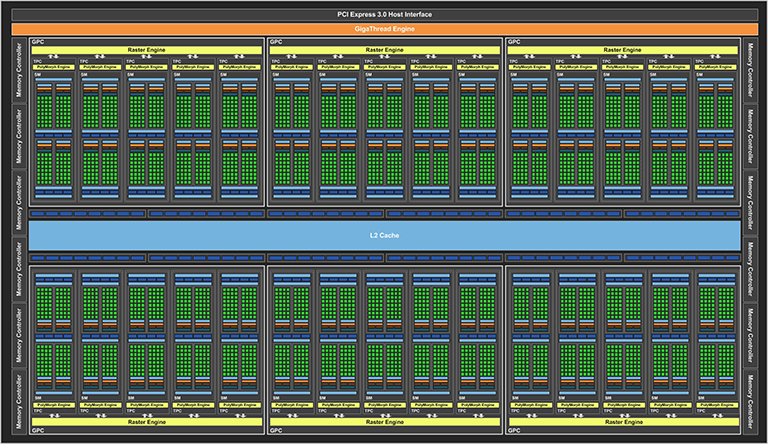

In [5]:
Image(filename=os.path.expanduser('~/Dropbox/ICL-2014/Presentations/2016-08-16-GPU/architecture.png'))

#libraries stats: https://twitter.com/fchollet/status/765212287531495424/photo/1?ref_src=twsrc%5Etfw

In [6]:
def DisplayArray(a, fmt='jpeg', rng=[0,1]):
    """Display an array as a picture."""
    a = (a - rng[0])/float(rng[1] - rng[0])*255
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [3]:
DEVICE = '/gpu:0'
sess = tf.InteractiveSession()

In [9]:
N = 400
dtVal = 0.25
disp = True

In [10]:
def init_float(shape, name):
#     return tf.Variable(tf.random_normal(shape, stddev=0.01), name=name)
    return tf.Variable(tf.zeros(shape), name=name)

def variable_summaries(var, name):
    """Attach a lot of summaries to a Tensor."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.scalar_summary('mean/' + name, mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_sum(tf.square(var - mean)))
        tf.scalar_summary('sttdev/' + name, stddev)
        tf.scalar_summary('max/' + name, tf.reduce_max(var))
        tf.scalar_summary('min/' + name, tf.reduce_min(var))
        tf.histogram_summary(name, var)


In [11]:
with tf.device(DEVICE):
    dt = tf.placeholder(tf.float32, shape=(), name='dt')
    tauv = tf.placeholder(tf.float32, shape=(), name='tauv')
    sim_index = tf.placeholder(tf.int32, shape=(), name='sim_index')

    scaling = 1 / (1/(2*2/dtVal))**0.5 * 70

    # Create variables for simulation state
    u = init_float([N,1], 'u')
    v = init_float([N,1], 'v')
    t = tf.Variable(0, dtype='float32')
    ind = tf.Variable(0, dtype='float32')
    
    LowSp = init_float([N,1], 'bursting')
    vv = init_float([N,1], 'spiking')
    
    vmean = tf.Variable(0, dtype='float32')
    umean = tf.Variable(0, dtype='float32')
    vvmean = tf.Variable(0, dtype='float32')
    imean = tf.Variable(0, dtype='float32')
    gammamean = tf.Variable(0, dtype='float32')
    

    # currents
    iBack = init_float([N,1], 'iBack')
    iEff = init_float([N,1], 'iEff')
    iGap = init_float([N,1], 'iGap')
    iChem = init_float([N,1], 'iChem')
    
    # synaptics connection
    conn = np.zeros([N, N], dtype='float32')
    sG = 10
    nbInCluster = int(N/2)
    for i in range(N):
        for j in range(N):
            conn[i][j] = ((i<(nbInCluster + sG)) & (j<(nbInCluster + sG)) ) \
            or ((i>=(nbInCluster - sG)) & (j>=(nbInCluster - sG)) )
    allowedConnections = tf.Variable(conn)
    nbOfGaps = np.sum(conn)
    
    g0 = 7 /nbOfGaps**0.5
    wGap_init = np.ones([N, N], dtype=np.float32)*g0
    wII_init = np.ones([N, N], dtype=np.float32)*500/N/dtVal
    
    wGap = tf.Variable(wGap_init * conn)
    WII = tf.Variable(wII_init)

    FACT = 1
    ratio = 15
    A_LTD  = 1e-0*4.7e-6 * FACT * N
    A_LTP = ratio * A_LTD
    
    TImean = 130.0
    TImean_simul = tf.ones([N,1], dtype='float32')*TImean
    TImean_init =  tf.concat(0,[tf.ones([int(N/2),1]), tf.zeros([N-int(N/2),1])]) * TImean
    
    spikes = init_float([4000,N], "spikes")

In [7]:
with tf.device(DEVICE):   
    with tf.name_scope('Currents'):
        # Discretized PDE update rules
        iChem_ = iChem + dt/5 * (-iChem + tf.matmul(WII,tf.to_float(vv)))
        
        # current
        iBack_ = iBack + dt/2 * (-iBack + tf.random_normal((N,1), mean=0.0, stddev=1.0, dtype=tf.float32, seed=None, name=None))  
        iEff_ = iBack_ * scaling + tf.select(tf.greater(tf.ones([N,1])*t,300), TImean_simul, TImean_init)
        iGap_ = tf.matmul(wGap,v) - tf.mul(tf.reshape(tf.reduce_sum(wGap, 0), (N,1)),v)

        I_ = iGap_ + iChem_ + iEff_
    
    # IZHIKEVICH
    with tf.name_scope('Izhikevich'):
        ind_ = ind + 1
        # voltage
        v_ = v + dt / tauv * (tf.mul((v + 60), (v +50)) - 20 * u + 8 * I_)
        # adaptation
        u_ = u + dt * 0.044 * (v_ + 55 - u)
        # spikes
        vv_ = tf.to_float(tf.greater(v_,25.0))
        # reset
        v_ = tf.mul(vv_,-40.0) + tf.mul((1-vv_),v_)
        u_ = u_ + tf.mul(vv_,(50.0))

    # bursting
    with tf.name_scope('bursting'):
        LowSp_ = LowSp + dt/10.0*(vv_ * 10.0 / dt - LowSp)
        p = tf.to_float(tf.greater(LowSp_,1.3))
    
    # plasticity
    with tf.name_scope('plasticity'):
        A = tf.matmul(p,tf.ones([1,N]))
        dwLTD_ = A_LTD*(A+tf.transpose(A))

        B = tf.matmul(vv_, tf.ones([1,N]))
        dwLTP_ = A_LTP*(tf.mul(tf.ones([N,N]) - 1/g0 * wGap, B+tf.transpose(B)))

        dwGap_ = dt * (dwLTP_ - dwLTD_)
        wGap_ = tf.mul(tf.clip_by_value(wGap+dwGap_, clip_value_min=0, clip_value_max=10**10), allowedConnections)

    # monitoring
    with tf.name_scope('Monitoring'):
        vmean_ = tf.reduce_mean(v_)
        umean_ = tf.reduce_mean(u_)
        imean_ = tf.reduce_mean(I_)
        vvmean_ = tf.reduce_sum(tf.to_float(vv_))
        gammamean_ = tf.reduce_mean(wGap_)

    with tf.name_scope('Raster_Plot'):
        spike_update = tf.scatter_update(spikes, sim_index,tf.reshape((vv_), (N,)))
    
    # Operation to update the state
    step = tf.group(
        v.assign(v_),
        vv.assign(vv_),
        u.assign(u_),
        iBack.assign(iBack_),
        iEff.assign(iChem_),
        LowSp.assign(LowSp_),
        wGap.assign(wGap_),
        vmean.assign(vmean_),
        umean.assign(umean_),
        imean.assign(imean_),
        vvmean.assign(vvmean_),
        )


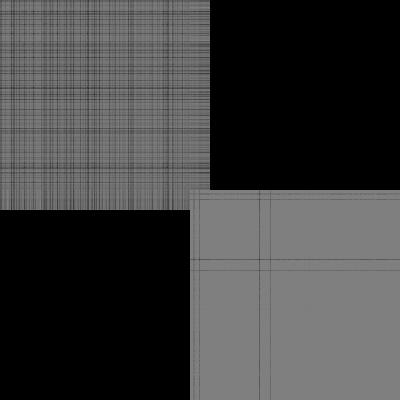

2.95


In [8]:
# Initialize state to initial conditions
sess.run(tf.initialize_all_variables())

vm=[]
um=[]
vvm=[]
im=[]
gamma=[]
t0 = time.time()
for i in range(400):
    # Step simulation
    sess.run([step], feed_dict={dt: dtVal, tauv: 15, sim_index: i})
    feed = {dt: dtVal, tauv: 15,sim_index: i}
    sess.run(spike_update, feed_dict=feed)
    vvm.append(vvmean.eval())
    
    # Visualize every 10 steps
    if i % 10 == 0:
        if disp:
            clear_output(wait=True)
            DisplayArray(wGap.eval(), rng=[0, 2*g0])
        vm.append(vmean.eval())
        um.append(umean.eval())
        im.append(imean.eval())
        gamma.append(gammamean.eval())
        
print('%.2f'%(time.time()-t0))

In [12]:
sp =tf.convert_to_tensor(spikes).eval()
plt.figure(figsize=(12,4))
extent=[0,400,0,300]
plt.imshow(sp.transpose(), extent=extent, aspect=0.3*(extent[1] - extent[0]) / (
            extent[3] - extent[2]))

FailedPreconditionError: Attempting to use uninitialized value spikes_1
	 [[Node: spikes_1/read = Identity[T=DT_FLOAT, _class=["loc:@spikes_1"], _device="/job:localhost/replica:0/task:0/gpu:0"](spikes_1)]]
	 [[Node: spikes_1/read/_1427 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_4_spikes_1/read", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]
Caused by op 'spikes_1/read', defined at:
  File "/mnt/DATA/gp1514/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/runpy.py", line 170, in _run_module_as_main
    "__main__", mod_spec)
  File "/mnt/DATA/gp1514/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/mnt/DATA/gp1514/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/mnt/DATA/gp1514/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/mnt/DATA/gp1514/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 442, in start
    ioloop.IOLoop.instance().start()
  File "/mnt/DATA/gp1514/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/mnt/DATA/gp1514/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/mnt/DATA/gp1514/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/mnt/DATA/gp1514/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/mnt/DATA/gp1514/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/mnt/DATA/gp1514/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/mnt/DATA/gp1514/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/mnt/DATA/gp1514/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/mnt/DATA/gp1514/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/mnt/DATA/gp1514/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "/mnt/DATA/gp1514/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/mnt/DATA/gp1514/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/mnt/DATA/gp1514/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2825, in run_ast_nodes
    if self.run_code(code, result):
  File "/mnt/DATA/gp1514/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-51d75caa2007>", line 56, in <module>
    spikes = init_float([4000,N], "spikes")
  File "<ipython-input-10-2671da39bf4c>", line 3, in init_float
    return tf.Variable(tf.zeros(shape), name=name)
  File "/mnt/DATA/gp1514/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 211, in __init__
    dtype=dtype)
  File "/mnt/DATA/gp1514/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 323, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/mnt/DATA/gp1514/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1106, in identity
    result = _op_def_lib.apply_op("Identity", input=input, name=name)
  File "/mnt/DATA/gp1514/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 703, in apply_op
    op_def=op_def)
  File "/mnt/DATA/gp1514/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2317, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/mnt/DATA/gp1514/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1239, in __init__
    self._traceback = _extract_stack()


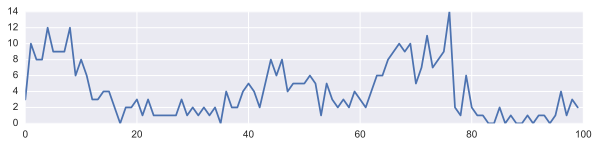

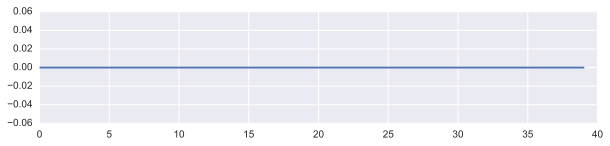

In [17]:
plt.figure(figsize=(10,2))
plt.plot(vvm[-100:])
plt.figure(figsize=(10,2))
plt.plot(np.array(gamma)*N**2)

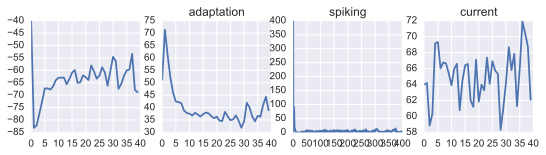

In [18]:
fig = plt.figure(figsize=(9,2))
ax0 = fig.add_subplot(141)
ax1 = fig.add_subplot(142)
ax2 = fig.add_subplot(143)
ax3 = fig.add_subplot(144)

ax0.plot(vm)

ax1.plot(um)
ax1.set_title('adaptation')

ax2.plot(vvm)
ax2.set_title('spiking')

ax3.plot(im)
ax3.set_title('current')